In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import matplotlib.patches as patches
from mountain_car import MountainCar


In [6]:

class AnimatedMountainCarVisualizer(MountainCar):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fig = None
        self.axes = None
        self.car_dot = None
        self.episode_text = None
        self.value_plot = None
        self.trajectory_line = None
        plt.style.use('dark_background')
    
    def calculate_value_function(self):
        """Calculate the state-value function for the current policy."""
        # Create position and velocity vectors for plotting
        vel_step = (self.vel_min_max[1] - self.vel_min_max[0]) / 50
        pos_step = (self.pos_min_max[1] - self.pos_min_max[0]) / 50
        
        vel_vec = np.arange(self.vel_min_max[0], self.vel_min_max[1] + vel_step, vel_step)
        pos_vec = np.arange(self.pos_min_max[0], self.pos_min_max[1] + pos_step, pos_step)
        
        value_function = np.zeros((len(vel_vec), len(pos_vec)))
        
        for i, vel in enumerate(vel_vec):
            for j, pos in enumerate(pos_vec):
                # Calculate -max Q(s,a) to match the visualization in the image
                value_function[i, j] = -max(self.q(vel, pos, a) for a in self.actions)
        
        return vel_vec, pos_vec, value_function
        
    def setup_animation(self, figsize=(15, 6)):
        """Initialize the animation figure and axes"""
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=figsize,
                                                     gridspec_kw={'width_ratios': [2, 1]})
        
        # Initialize value function plot
        vel_vec, pos_vec, value_function = self.calculate_value_function()
        norm_value = (value_function - value_function.min()) / (value_function.max() - value_function.min())
        self.value_plot = self.ax1.imshow(norm_value, 
                                         extent=[self.pos_min_max[0], self.pos_min_max[1],
                                                self.vel_min_max[0], self.vel_min_max[1]],
                                         aspect='auto', origin='lower', cmap='YlOrRd_r')
        
        plt.colorbar(self.value_plot, ax=self.ax1)
        self.ax1.set_xlabel('position, x')
        self.ax1.set_ylabel('velocity, ẋ')
        
        # Initialize mountain plot
        x = np.linspace(self.pos_min_max[0], self.pos_min_max[1], 100)
        y = np.sin(3 * x) * 0.45 + 0.55
        self.ax2.plot(x, y, 'coral', linewidth=2)
        self.ax2.set_xlim(self.pos_min_max[0], self.pos_min_max[1])
        self.ax2.set_ylim(0, 1.1)
        self.ax2.axis('off')
        
        # Initialize car marker
        self.car_dot, = self.ax2.plot([], [], 'o', color='lightblue', markersize=10)
        
        # Initialize trajectory line
        self.trajectory_line, = self.ax1.plot([], [], color='white', linewidth=2, alpha=0.8)
        
        # Add episode text
        self.episode_text = self.ax1.text(0.02, 1.05, '', transform=self.ax1.transAxes)
        
        plt.tight_layout()
        
    def update_animation(self, episode):
        """Update function for animation"""
        # Update value function
        vel_vec, pos_vec, value_function = self.calculate_value_function()
        norm_value = (value_function - value_function.min()) / (value_function.max() - value_function.min())
        self.value_plot.set_array(norm_value)
        
        # Update episode text
        self.episode_text.set_text(f'Episode: {episode}')
        
        # Update trajectory and car position
        episode_data = self.results[self.results['episode'] == episode]
        
        # Update trajectory line
        self.trajectory_line.set_data(episode_data['pos'], episode_data['vel'])
        
        # Update car position
        final_pos = episode_data['pos'].iloc[-1]
        final_height = np.sin(3 * final_pos) * 0.45 + 0.55
        self.car_dot.set_data([final_pos], [final_height])
        
        return self.value_plot, self.car_dot, self.trajectory_line, self.episode_text
        
    def create_animation(self, episode_step=1):
        """Create animation of the learning process"""
        self.setup_animation()
        
        episodes = range(0, self.results['episode'].max() + 1, episode_step)
        anim = FuncAnimation(self.fig, self.update_animation, frames=episodes,
                           interval=100, blit=True)
        
        return anim

In [7]:

def run_and_animate(alpha=0.1, distance_scaler=0.25, n_steps=4, episodes=500, episode_step=10):
    """
    Run the mountain car problem and create animation.
    
    Parameters:
    -----------
    alpha : float
        Learning rate
    distance_scaler : float
        Distance scaling factor for RBF
    n_steps : int
        Number of steps for n-step SARSA
    episodes : int
        Number of episodes to run
    episode_step : int
        Number of episodes to skip between frames
    """
    # Initialize and run
    car = AnimatedMountainCarVisualizer(
        alpha=alpha,
        distance_scaler=distance_scaler,
        n=n_steps
    )
    
    print(f"Training for {episodes} episodes...")
    car.run(episodes)
    
    print("\nCreating animation...")
    anim = car.create_animation(episode_step=episode_step)
    
    # Save animation
    writer = PillowWriter(fps=10)
    anim.save('mountain_car_learning.gif', writer=writer)
    
    return car, anim

Training for 500 episodes...


100%|██████████| 500/500 [02:57<00:00,  2.82it/s]



Creating animation...


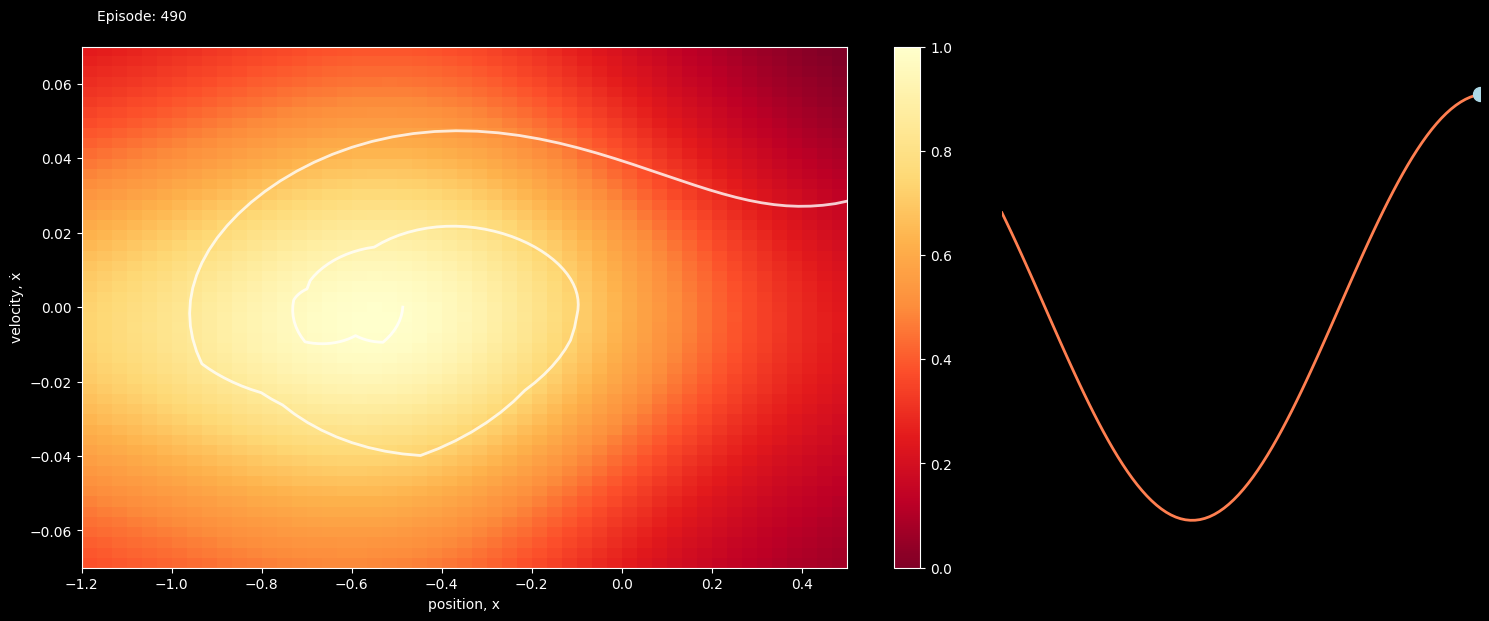

In [8]:
car, anim = run_and_animate(episodes=500, episode_step=10)